## How did the 2022 ferry fare hike affect ridership?
## And how migh future fare hikes affect ridership?

In 2022, the NYC Ferry instituted the first fare hike in the system's then-six-year history, raising the price of a single ride from 2.75--cheaper than the subway--to 4.00, but also creating a 10-ride pass, valid for three months, that costs $27.50. Though driven by an effort to decrease the ferry's per-rider subsidy and become more financially self-sufficient, such a large fare increases may also depress ridership. The following analaysis evaluates this question using ferry ridership data. It focuses on whether the fare hike uniquely impacted ridership at ferry landings near alternative forms of transit.

## Contents:
0. Import relevant packages and load in riderhsip data
1. Summarize ferry data over time

3. Assess graphically how proximity to alternative transit is associated with ferry ridership after the fare hike

4. Assess how proximity to alternative transit is associated with ferry ridership after the fare hike using a differences-in-differences approach.

   a. Prepare data for regression analysis: Merge weather data, create dummy variables for fixed effects, create interaction terms, and seasonally adjust the data

   b. Perform regression analysis, report coefficients

5. Placebo test
6. Analysis

## Step 0: Load in Ridership Data and packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

ridership_data = pd.read_csv(r"C:\Users\WalshM\OneDrive - NYC Office of Management and Budget\Summer Project - NYC Ferry\Data\NYC_Ferry_Ridership_20240802.csv")

## Step 1: Summarize the data
Descriptively, since the ferry's inception, how has ridership changed and specifically how did it change around the fare hike? The graph below, showing seasonally-adjusted daily ridership, shows it was on an upward trend, with no dip after the fare hike in September 2022. But this may belie a real impact, given that ridership was trending upward anyways.

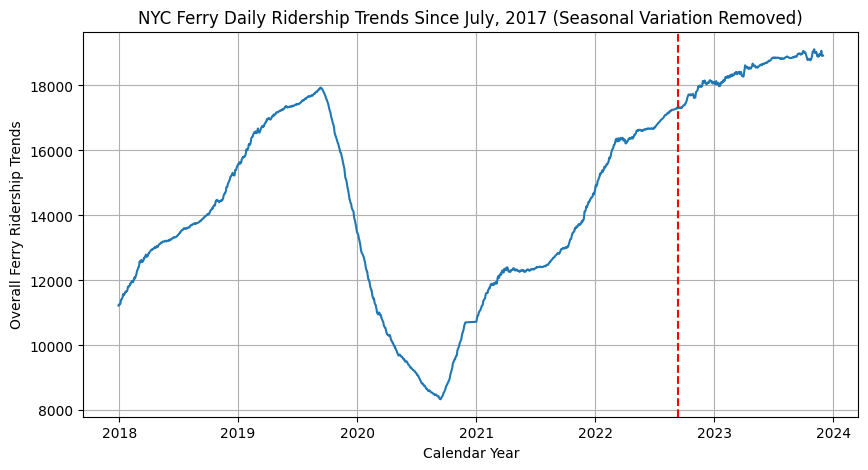

In [2]:
## Covert date column to datetime so that we can summarize total daily ridership across the system over time

ridership_data['Date']=pd.to_datetime(ridership_data['Date'])
ridership_data['Month/Year']=pd.to_datetime(ridership_data['Date'].dt.month.astype(str)+ridership_data['Date'].dt.year.astype(str), format = '%m%Y')
ridership_data_daystop = ridership_data.pivot_table(index = 'Date',
                                                   values = 'Boardings',
                                                   aggfunc = 'sum').reset_index()

import statsmodels.api as sm
import matplotlib.pyplot as plt

ridership_data_daystop = ridership_data.pivot_table(index = 'Date',
                                                   values = 'Boardings',
                                                   aggfunc = 'sum').reset_index()

## Ridership is extremely seasonally dependent: More people take the ferry in warmer months, so we need to seasonally adjust the data

result = sm.tsa.seasonal_decompose(ridership_data_daystop['Boardings'], model='additive', period=365)  # Adjust 'period' based on your data's seasonality

trend = result.trend
seasonal = result.seasonal
residual = result.resid

## Plot seasonal ridership

plt.figure(figsize=(10,5))
plt.grid(True)
plt.title(label='NYC Ferry Daily Ridership Trends Since July, 2017 (Seasonal Variation Removed)')
plt.xlabel(xlabel='Calendar Year')
plt.ylabel(ylabel='Overall Ferry Ridership Trends')

plt.plot(ridership_data_daystop['Date'],trend, label='Trend')
plt.axvline(x=pd.to_datetime('2022-09-12'), color='red', linestyle='--', label='Fare Hike Date')  # Add vertical line


# 2. Prepare Data

Our hypothesis is that while overall system ridership did not fall after the fare hike, ridership did not increase as much as it would have, especially at ferry landings where there were significant alternative non-ferry options. In other words, the price-elasticity of demand was higher for riders who had alternative options (i.e., someone who lived 0.3 mi from both a ferry landings and a subway stop) compared to someone who lives 0.3 mi from a ferry landing but 1 mi from a subway stop.


*NOTE*: *Below, we simply calculate the distance between ferry landings and subway stations. In reality, ferry landings are on the waterfront, and most ferry riders live at least somewhat inland from ferry landings. So, the actual distance from most ferry riders' homes to their closest subway station is a bit shorter than the distance between the ferry landing and the subway. However, the most granular ferry ridership data we have is at the stop level, and the distance between the landing and the subway stop is a good proxy for the distance that commuters face.*

## 2a. For every ferry landing, determine its proximity to every subway station

In [3]:
## Load in subway and ferry stops, rename geography columns to specify the dataset it comes from 

subway_stops = pd.read_excel(r"C:\Users\WalshM\OneDrive - NYC Office of Management and Budget\Summer Project - NYC Ferry\Data\Transportation\subway_stops_data.xlsx")
ferry_stops = pd.read_csv(r"C:\Users\WalshM\OneDrive - NYC Office of Management and Budget\Summer Project - NYC Ferry\Data\Transportation\ferry_stops_data.csv")

ferry_stops=ferry_stops.rename(columns={'stop_lon':'ferry_lon', 'stop_lat':'ferry_lat'})
subway_stops=subway_stops.rename(columns={'stop_lon':'subway_lon', 'stop_lat':'subway_lat'})

## Drop duplicate rows (i.e., subway stops that are a different entrance but have the same coordinates)
subway_stops['Coordinates'] = subway_stops['subway_lat'].astype(str)+'/'+subway_stops['subway_lon'].astype(str)
subway_stops=subway_stops.drop_duplicates(subset='Coordinates')

## Create cartesian product mapping every subway station to a ferry landing; this was we can determine the distance between each pair

import itertools
cartesian_product = pd.DataFrame(itertools.product(subway_stops.values.tolist(), ferry_stops.values.tolist()),columns=['Subway Stops', 
                                                                                                                       'Ferry Stops'])
#Flatten the tuples into columns

subway_df = cartesian_product['Subway Stops'].apply(pd.Series)
subway_df.columns = [f"Subway_{col}" for col in subway_df.columns]
ferry_df = cartesian_product['Ferry Stops'].apply(pd.Series)
ferry_df.columns = [f"Ferry_{col}" for col in ferry_df.columns]

# Combine the dataframes with prefixed column names, then rename the column:

cartesian_product = pd.concat([subway_df, ferry_df], axis=1)
cartesian_product.rename(columns={'Subway_2': 'Subway Stop Name', 'Subway_3': 'Subway_Stop_Latitude', 
                                  'Subway_4': 'Subway_Stop_Longitude', 'Ferry_3': 'Ferry Stop Name',
                                  'Ferry_18': 'Ferry_Stop_Latitude', 'Ferry_17': 'Ferry_Stop_Longitude'}, 
                         inplace=True)

## Create a new dataframe that's our subway-ferry mapping matrix
subway_ferry_matrix = cartesian_product[['Subway Stop Name',
'Subway_Stop_Latitude', 
'Subway_Stop_Longitude',
'Ferry Stop Name',
'Ferry_Stop_Latitude',
'Ferry_Stop_Longitude']]


## Define function to calculate distance between ferry landings and subway stops for each row

def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=3963):
    
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

subway_ferry_matrix['Distance between Ferry and Subway Stop'] = subway_ferry_matrix.apply(lambda row: haversine(row['Subway_Stop_Latitude'],
                                                                                                                    row['Subway_Stop_Longitude'],
                                                                                                                    row['Ferry_Stop_Latitude'],
                                                                                                                    row['Ferry_Stop_Longitude']), axis=1,
                                                                                                                      result_type = 'expand')

## Determine, for each ferry landing, if the distance is less than 0.5 mi to a subway, between 0.5 mi and 0.75 mi, or between 0.75 mi and 1.00 mi
    
def less_than_x(distance):
    if distance<=0.5:
        return 'Less than 0.5mi'
    elif 0.5<distance<=0.75:
        return 'Between 0.5 and 0.75mi'
    elif 0.75<distance<=1.00:
        return 'Between 0.75 and 1.00mi'
    else:
        return 'No'

subway_ferry_matrix['Close to Alternative Options?'] = subway_ferry_matrix['Distance between Ferry and Subway Stop'].apply(less_than_x)

## Create dummy variables indicating whether a ferry landing is close to a subway stop
subway_ferry_matrix_dummies = pd.get_dummies(subway_ferry_matrix, columns=['Close to Alternative Options?'])

## Pivot table to determine, for each ferry stop, how many nearby subway stops there are
alternative_ferry_options = subway_ferry_matrix_dummies.pivot_table(index = 'Ferry Stop Name',
                                values = ['Close to Alternative Options?_Between 0.5 and 0.75mi',
                                          'Close to Alternative Options?_Between 0.75 and 1.00mi',
                                          'Close to Alternative Options?_Less than 0.5mi',
                                          'Close to Alternative Options?_No'],
                                aggfunc = 'sum')

## Determine total subway stops within 1 mile
alternative_ferry_options['Total Alternatives within 1 mile'] = alternative_ferry_options['Close to Alternative Options?_Between 0.5 and 0.75mi']+ \
                                                                alternative_ferry_options['Close to Alternative Options?_Between 0.75 and 1.00mi']+ \
                                                                alternative_ferry_options['Close to Alternative Options?_Less than 0.5mi']

## The St. George Ferry landing on Staten Island has no subway "alternatives" given that you cannot take the subway from Staten Island
alternative_ferry_options.at['St. George', 'Close to Alternative Options?_Between 0.5 and 0.75mi'] = 0
alternative_ferry_options.at['St. George', 'Close to Alternative Options?_Less than 0.5mi'] = 0
alternative_ferry_options.at['St. George', 'Total Alternatives within 1 mile'] = 0
alternative_ferry_options.at['St. George', 'Distance between Ferry and Subway Stop'] = np.nan
alternative_ferry_options.at['St. George', 'Close to Alternative Options?_No'] = 496


C:\Users\local_WalshM\Temp\ipykernel_12544\303422693.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_ferry_matrix['Distance between Ferry and Subway Stop'] = subway_ferry_matrix.apply(lambda row: haversine(row['Subway_Stop_Latitude'],
C:\Users\local_WalshM\Temp\ipykernel_12544\303422693.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subway_ferry_matrix['Close to Alternative Options?'] = subway_ferry_matrix['Distance between Ferry and Subway Stop'].apply(less_than_x)


## 3. Assess graphically how proximity to alternative transit is associated with ferry ridership after the fare hike


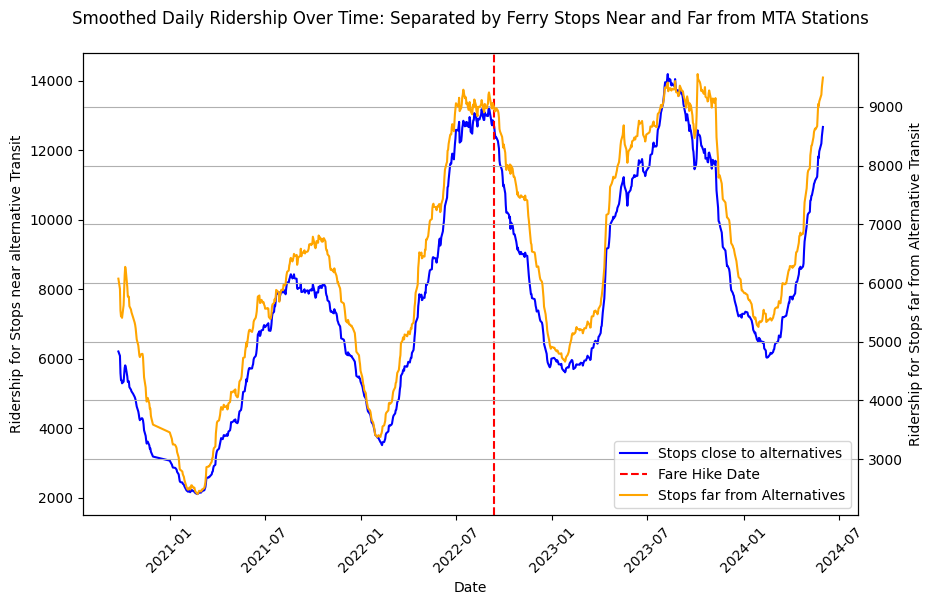

In [4]:
## Define function to create two subsets of our larger ridership dataframe: 
## The rows for stops close to alternative transit and those far from alternative transit 
## (Close = at least one subway less than 0.5 mi from ferry landing) 

## THe function also lets us specify a window. For a window of X, we look at data X days before and X days after the cutoff date

def create_subsets(distance, window_days):

    ridership_data['Pre_Post_Hike'] = np.where(ridership_data['Date'] >= pd.to_datetime('2022-09-12 08:00:00'), 'Post-Hike', 'Pre-Hike')  
    ridership_data_bydaystop = ridership_data[ridership_data['TypeDay']=='Weekday'].pivot_table(index = ['Stop', 'Date'],
                                                                        values = 'Boardings',
                                                                        aggfunc = 'sum').reset_index()
    ridership_analysis_agg = pd.merge(ridership_data_bydaystop,  alternative_ferry_options, left_on='Stop', right_on='Ferry Stop Name') 
    ridership_analysis_agg['Close to Alternatives'] = np.where(ridership_analysis_agg['Close to Alternative Options?_Less than 0.5mi'] > 0, 1, 0)
    ridership_analysis_agg['Days Since Fare Hike'] = (ridership_analysis_agg['Date'] - pd.to_datetime('2022-09-12 08:00:00')).dt.days
    ridership_analysis_agg_window=ridership_analysis_agg[(ridership_analysis_agg['Days Since Fare Hike'] >= window_days*-1) & (ridership_analysis_agg['Days Since Fare Hike'] <= window_days)]

    if distance == 'Close':
        subset = ridership_analysis_agg_window[ridership_analysis_agg_window['Close to Alternatives']==1]
    else:
        subset = ridership_analysis_agg_window[ridership_analysis_agg_window['Close to Alternatives']==0]

    subset=subset.pivot_table(index='Date',values='Boardings',aggfunc='sum').reset_index()
    subset['Boardings_Smoothed']=subset['Boardings'].rolling(window=28, min_periods=1).mean()

    return subset

## Create our subsets by executing the function 
subset_close = create_subsets('Close', 720)
subset_far = create_subsets('Far', 720)

## Plot the graph

fig, ax1 = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=45)

ax1.plot(subset_close['Date'][2:], subset_close['Boardings_Smoothed'][2:], linestyle='-',
       label = 'Stops close to alternatives', color='blue')


ax1.set_xlabel('Date')
ax1.set_ylabel('Ridership for Stops near alternative Transit')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

ax2.plot(subset_far['Date'][2:], subset_far['Boardings_Smoothed'][2:], linestyle='-',
       label = 'Stops far from Alternatives', color='Orange')


ax2.set_xlabel('Date')
ax2.set_ylabel('Ridership for Stops far from Alternative Transit')
ax2.tick_params(axis='y')
plt.grid(True)

ax1.axvline(x=pd.to_datetime('2022-09-12 08:00:00'), color='red', linestyle='--', label='Fare Hike Date')  # Add vertical line

plt.title('Smoothed Daily Ridership Over Time: Separated by Ferry Stops Near and Far from MTA Stations\n')
plt.xlabel('Time')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

# Add a combined legend in the upper right
plt.legend(lines, labels, loc='lower right')

# 4. Assess how proximity to alternative transit is associated with ferry ridership after the fare hike using a differences-in-differences approach.

## 4a. Prepare data for regression analysis, execute differences-in-differences regression 

These tasks all occur within one large function called "**diff_in_diff**". The function does the following:

1. Organizes data by pre/post fare hike and filters the dataset to only include a preset window of dates
2. Merges weather data
3. Creates dummy variables for fixed effects
4. Creates interaction terms
5. Executes regression and prints an output table
6. Puts our two interaction-term coefficients of interest and their p-values into a dictionary for a later placebo test

In [5]:
## Initialize an empty dictionary to store regression results for coefficients of interest.

data_dictionary = {}

In [11]:

ridership_data_rush_hour = None
ridership_data_bydaystop = None
ridership_analysis_agg = None
ridership_analysis_agg_window = None
ridership_data_with_weather = None
ridership_data_with_weather1 = None
seasonal = None
reg_results = None

def rush_hour(hour):
    if 5<=hour<=10:
        return 1
    elif 16<=hour<=20:
        return 1
    else:
        return 0

def morning_rush_hour(hour):
    if 5<hour<=10:
        return 1
    else:
        0

def no_rush_hour(hour):
    return 1

def diff_in_diff(cutoff_date, rush_hour_function, window_days):

    
    ## Define functions that filter dataset into a preset window and filters out non-rush-hour rides

    
    ## Now, define function to filter our dataset both by rush hour ridership and by the window of time we are analyzing
    
    def set_rush_hour_and_window(rush_hour_function, window_days):
    
        ridership_data['Rush Hour?']=ridership_data['Hour'].apply(rush_hour_function)
    
        ridership_data['Pre_Post_Hike'] = np.where(ridership_data['Date'] >= pd.to_datetime(cutoff_date), 'Post-Hike', 'Pre-Hike')    
    
        ridership_data_rush_hour = ridership_data[ridership_data['Rush Hour?']==1]
        
        ridership_data_bydaystop = ridership_data_rush_hour[ridership_data_rush_hour['TypeDay']=='Weekday'].pivot_table(index = ['Stop', 'Date'],
                                                                        values = 'Boardings',
                                                                        aggfunc = 'sum').reset_index()
    
    
        ## Critically, we must **seasonally adjust** ridership. Not seasonally adjusting could bias the results: 
        ## The fare hike occurred in mid-Septermber 2022. 
        ## During September, weather begins to get cooler, and enthusiasm for the ferry naturally decreases. 
        ## We should expect the effect of weather to be larger at stops with more alternatives: 
        ## On a cold and windy day, people who can reasonably walk to the subway are more likely to take the subway,
        ## whereas we expect people farther from subway stops are more likely to hold out for the ferry instead.        
        
        import statsmodels.api as sm

        result=sm.tsa.seasonal_decompose(ridership_data_bydaystop['Boardings'], model='additive', period=365)
        seasonal = result.seasonal
        ridership_data_bydaystop = pd.merge(ridership_data_bydaystop, pd.DataFrame(seasonal),right_index=True,
                                                         left_index=True)

        ## Now, for each observation, merge our dataset that tells us how far ferry landings are from subway stops
        ridership_analysis_agg = pd.merge(ridership_data_bydaystop,  alternative_ferry_options, left_on='Stop', right_on='Ferry Stop Name') 
        ridership_analysis_agg['Days Since Fare Hike'] = (ridership_analysis_agg['Date'] - pd.to_datetime(cutoff_date)).dt.days
        ridership_analysis_agg_window=ridership_analysis_agg[(ridership_analysis_agg['Days Since Fare Hike'] >= window_days*-1) & (ridership_analysis_agg['Days Since Fare Hike'] <= window_days)]
    
        ## We return two dataframes: One is a dataset filtered by rush hour and by window, and the other is filtered by just rush hour
        
        return [ridership_analysis_agg_window,ridership_data_bydaystop]
    
    ridership_analysis_agg_window=set_rush_hour_and_window(rush_hour, window_days)[0]
    ridership_data_bydaystop = set_rush_hour_and_window(rush_hour, window_days)[1]
    
    ## Load and merge weather data: weather -- both seasonally and day-to-day -- is a strong predictor of whether people will ride the ferry
    
    weather = pd.read_csv(r"C:\Users\WalshM\NYC Office of Management and Budget\grp_HED - Documents\Econdev\Agency - EDC\Expense Programs\1. Existing\NYC Ferry - TO REFILE\Ferry Model\NYC_Weather.csv")
    weather['DATE']=pd.to_datetime(weather['DATE'])
    
    ridership_data_with_weather = pd.merge(ridership_analysis_agg_window.reset_index(), weather, left_on = 'Date', right_on = 'DATE')
    
    ## Create fixed effects
    
    #### Time-trend fixed effects
    ridership_data_with_weather['system_time_trend'] = (ridership_data_with_weather['Date'] - ridership_data_with_weather['Date'].min()).dt.days
    
    #### Stop time trend fixed effects
    ridership_data_with_weather['stop_time_trend'] = ridership_data_with_weather.groupby('Stop')['system_time_trend'].transform(lambda x: x - x.mean())
    
    ridership_data_with_weather = pd.concat([ridership_data_with_weather, pd.get_dummies(ridership_data_with_weather['Stop'], prefix='stop')], axis=1)
    for stop in ridership_data_with_weather['Stop'].unique():
        ridership_data_with_weather[f'trend_{stop}'] = ridership_data_with_weather['system_time_trend'] * ridership_data_with_weather[f'stop_{stop}']
    
    #### Day fixed effects
    day_dummies = pd.get_dummies(ridership_data_with_weather['Date'], prefix = 'fixed_eff_day')
    day_dummies = day_dummies.astype(int)
    ridership_data_with_weather1 = pd.merge(ridership_data_with_weather, day_dummies, how='left', left_index=True, right_index=True)
    
    #### Day of the week fixed effects (perhaps riders are more likely to take the ferry on Friday than Tuesday)
    ridership_data_with_weather1['Day of Week']=ridership_data_with_weather1['Date'].dt.weekday
    ridership_data_with_weather1 = pd.get_dummies(ridership_data_with_weather1, columns=['Day of Week'], prefix='Day', drop_first=True)
    ridership_data_with_weather1[['Day_1', 'Day_2', 'Day_3', 'Day_4']] = ridership_data_with_weather1[['Day_1', 'Day_2', 'Day_3', 'Day_4']].astype(int)
    
    
    #### Month fixed effects
    ridership_data_with_weather1['Month'] = ridership_data_with_weather1['Date'].dt.month
    ridership_data_with_weather1 = pd.get_dummies(ridership_data_with_weather1,  columns=['Month'], prefix='Month', drop_first=True)
    ridership_data_with_weather1[['Month_2', 'Month_3', 
                                  'Month_4','Month_5','Month_6','Month_7',
                                  'Month_8','Month_9','Month_10','Month_11','Month_12']]=ridership_data_with_weather1[['Month_2', 'Month_3', 
                                  'Month_4','Month_5','Month_6','Month_7',
                                  'Month_8','Month_9','Month_10','Month_11','Month_12']].astype(int)
    
    ## Create dummy variables
    
    #### Create a dummy variable representing whether our day is before or after the fare hike, for our diff-in-diff
    ridership_data_with_weather1['Fare Increase Dummy'] = np.where(ridership_data_with_weather1['Days Since Fare Hike'] >= 0, 1, 0)
    
    #### Create a dummy variable representing whether the observation occurred shortly after the fare increase or not
    def within_small_window(date):
        if 0<date<60:
            return 1
        else:
            return 0
    ridership_data_with_weather1['30 days post fare hike']=ridership_data_with_weather1['Days Since Fare Hike'].apply(within_small_window)
    
    #### Create a dummy variable representing whether an observation is within 0.5 mi of a subway stop and thus close to alternatives
    
    ridership_data_with_weather1['Close to Alternatives'] = np.where(ridership_data_with_weather1['Close to Alternative Options?_Less than 0.5mi'] > 0, 1, 0)
    
    #### Create a fixed effect for the interaction between the temperature and the stop. We do this because it may already be the case that 
    #### commuters who are near ferry landings and subway stations will be more sensitive to fluctuations in weather
    ridership_data_with_weather1['Temp_Stop_Interaction']=ridership_data_with_weather1['Close to Alternatives']*ridership_data_with_weather1['TMAX']
    
    #### Create interaction terms between a) proximity to alternatives and b) our dummy for whether our observation is pre/post fare hike.
    #### This is the key coefficient of interest: It tells us if, after the fare increase, ridership at ferry landings where riders had
    #### abundant other options.
    
    #### The discrete version interacts the dummy variable for proximity to alternatives with the fare hike dummy, whereas 
    #### the continuous version interacts total subway stops within one mile (continuous variable) with the fare hike dummy
    
    ridership_data_with_weather1['Fare Increase x Close to Alternatives (Discrete)']=ridership_data_with_weather1['Fare Increase Dummy']*ridership_data_with_weather1['Close to Alternatives']
    ridership_data_with_weather1['Fare Increase x Close to Alternatives (Continuous)']=ridership_data_with_weather1['Fare Increase Dummy']*ridership_data_with_weather1['Total Alternatives within 1 mile']
    
    #### This is another key coefficient of interest: It tells us if any differential impact on ridership for landings near subway stops
    #### was especially acute in the period directly after the fare hike
    
    ridership_data_with_weather1['Fare Increase x Close to Alternatives x Window (Discrete)']=ridership_data_with_weather1['Fare Increase x Close to Alternatives (Discrete)']*ridership_data_with_weather1['30 days post fare hike']
    ridership_data_with_weather1['Fare Increase x Close to Alternatives x Window (Continuous)']=ridership_data_with_weather1['Fare Increase x Close to Alternatives (Continuous)']*ridership_data_with_weather1['30 days post fare hike']
    
    #### This interaction term simply tells us whether, across both types of landings (near and far from alternatives), the fare increase
    #### was associated with an increase or decrease in ridership.
    ridership_data_with_weather1['Fare Increase x Window']=ridership_data_with_weather1['Fare Increase Dummy']*ridership_data_with_weather1['30 days post fare hike']
    
    
    ridership_data_with_weather1['Fare Increase x Close to Alternatives x Days Since Fare Increase (Discrete)']=ridership_data_with_weather1['Fare Increase x Close to Alternatives (Discrete)']*ridership_data_with_weather1['Days Since Fare Hike']
    ridership_data_with_weather1['Fare Increase x Close to Alternatives x Days Since Fare Increase (Continuous)']=ridership_data_with_weather1['Fare Increase x Close to Alternatives (Continuous)']*ridership_data_with_weather1['Days Since Fare Hike']
    
    ## Create rows for our fixed effects variables, so that we can easily add them to the regression model
    
    fixed_effs_stops = [x for x in list(ridership_data_with_weather1.columns) if type(x)==str and 'fixed_eff__' in x]
    stop_trends = [x for x in list(ridership_data_with_weather1.columns) if type(x)==str and 'trend_' in x]
    fixed_eff_days = [x for x in list(ridership_data_with_weather1.columns) if type(x)==str and 'fixed_eff_day' in x]
    fixed_eff_months = [x for x in list(ridership_data_with_weather1.columns) if type(x)==str and 'fixed_eff_Month' in x]
       
    ## Set seasonally adjusted ridership as our y variable
    
    y=ridership_data_with_weather1['seasonal']
    
    ## X variables are our key coefficients of interest, main effects and interaction terms, weather controls, and our fixed effects vectors
    
    X=ridership_data_with_weather1[['Total Alternatives within 1 mile','Fare Increase x Close to Alternatives (Continuous)',
                           'TMAX', 'PRCP','system_time_trend', 'Fare Increase Dummy',
                                  '30 days post fare hike',
                                    'Fare Increase x Window',
                                    'Fare Increase x Close to Alternatives x Window (Continuous)',
                                    'Fare Increase x Close to Alternatives x Days Since Fare Increase (Continuous)',
                                    'Temp_Stop_Interaction',
                                   ]+fixed_effs_stops + fixed_eff_months]
    
    X = sm.add_constant(X)
    
    ## Fit the model with robust standard errors
    
    model = sm.OLS(y, X.astype(float)).fit(cov_type ='HC3')
    
    ## Print results for our coefficients of interest, then turn the statsmodels table into a dataframe
    reg_results = model.summary().tables[1]
    reg_results = pd.DataFrame(reg_results.data[1:], columns=reg_results.data[0])

    ## Turn regression result parameters into float data types
    reg_results['coef'] = reg_results['coef'].str.replace(" ", "").astype(float)
    reg_results['z'] = reg_results['z'].str.replace(" ", "").astype(float)

    ## Create new variables representing the coefficients and z-scores for our 

    coefficient_first_interaction = reg_results.loc[2, 'coef']
    p_val_first_interaction = reg_results.loc[2, 'P>|z|']

    coefficient_second_interaction = reg_results.loc[9, 'coef']
    p_val_second_interaction = reg_results.loc[9, 'P>|z|']    

    coefficient_third_interaction = reg_results.loc[8, 'coef']
    p_val_third_interaction = reg_results.loc[8, 'P>|z|'] 

    data_dictionary[cutoff_date] = [coefficient_first_interaction ,p_val_first_interaction, coefficient_second_interaction,
                                    p_val_second_interaction,
                                   coefficient_third_interaction,p_val_third_interaction]

    ## When we run the function, we want to return the entire regression output table
    


# 5: Perform placebo tests

We perform a placebo test, using other cutoff dates instead of the actual fare-hike date, to see whether applying the "treatment" of a fare hike on a different date also yields a significant result. We loop through seven placebo dates -- three occur on the same day (9/12) but in 2021, 2020, and 2019 and four occur on 2/12 (seven months before 9/12) in 2022, 2021, 2020, and 2019.

**Analysis of Results:** From the results below, we some evidence that ridership declined very modestly more for landings that were close to alternative forms of transit: A coefficient of -0.56 on the margin of significance indicates that for every additional nearby subway option within a mile walk from the ferry landing, ferry ridership declined by an additional 0.56 riders per day. This translates to about 17 rides per month and 204 rides per year, which is rather modest. *The fact that the coefficient for February 2020 has a much larger magnitude calls into question whether our marginally significant result has much meaning.* 

For the other interaction term of interest -- which captures how changes in ridership after the fare hike differed depending on how recent the fare hike was -- the coefficient is significant and positive, which contradicts our expectation: It means that the a decline in ridership for landings near alternatives was not larger in the period directly after fare increases. 

Finally, the interaction between the fare increase dummy and the dummy representing whether we are 60 days after the cut-off or not is not negative, meaning that for *all* ferry landings, the fare hike did not result in an immediate drop in ridership.

In [14]:
cutoff_dates_for_placebo = ['2022-09-12 08:00:00','2021-09-12 08:00:00','2020-09-12 08:00:00','2019-09-12 08:00:00',
                '2022-02-12 08:00:00','2021-02-12 08:00:00','2020-02-12 08:00:00','2019-02-12 08:00:00']

for date in cutoff_dates_for_placebo:
    diff_in_diff(date, rush_hour, 720)

coefficient_table = pd.DataFrame(data_dictionary).transpose().reset_index().rename(columns={'index': 'Cutoff Date for Placebo Test',
                                                          0:'Coefficient_Fare Increase X Close to Alternatives',
                                                          1: 'p_val_Fare Increase X Close to Alternatives',
                                                          2: 'Coefficient_Fare Increase X Close to Alternatives x Window',
                                                          3: 'p_val_Fare Increase X Close to Alternatives x Window',
                                                          4: 'Coefficient_Fare Increase X Window',
                                                          5: 'p_val_Fare Increase X Window'})
coefficient_table

,Cutoff Date for Placebo Test,Coefficient_Fare Increase X Close to Alternatives,p_val_Fare Increase X Close to Alternatives,Coefficient_Fare Increase X Close to Alternatives x Window,p_val_Fare Increase X Close to Alternatives x Window,Coefficient_Fare Increase X Window,p_val_Fare Increase X Window
0,2022-09-12 08:00:00,-0.5601,0.000,0.8182,0.000,0.2771,0.637
1,2021-09-12 08:00:00,0.0822,0.217,-0.2456,0.009,-1.101,0.063
2,2020-09-12 08:00:00,0.0019,0.982,-0.1396,0.419,2.3309,0.003
3,2019-09-12 08:00:00,-0.053,0.540,1.3707,0.000,-4.097,0.000
4,2022-02-12 08:00:00,0.2372,0.000,0.0883,0.382,-1.5007,0.009
5,2021-02-12 08:00:00,-0.1968,0.009,1.2584,0.000,-1.4314,0.050
6,2020-02-12 08:00:00,-0.1883,0.023,1.0965,0.000,-5.1261,0.000
7,2019-02-12 08:00:00,0.261,0.006,-0.5102,0.000,0.1073,0.875
